In [1]:
%matplotlib inline
import os
import sys

#import tensorflow as tf

import keras
import matplotlib.pyplot as plt

import numpy as np

from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, Add, Dropout, Concatenate, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import regularizers
from keras.applications.imagenet_utils import preprocess_input

from sklearn.model_selection import train_test_split
import pandas as pd

import zipfile
import io
from PIL import Image
from tqdm import tqdm
import math
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import cv2

random_state = 42
THRESHOLD = 0.05

def resblock(x, filters=64, kernel_size=(3, 3), activation='relu'):
    x_ = Conv2D(filters, kernel_size, padding='same')(x)
    x_ = BatchNormalization()(x_)
    x_ = Conv2D(filters, kernel_size, padding='same')(x_)
    x = Add()([x_, x])
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def resblock2(x, filters=64, kernel_size=(3, 3), activation='relu'):
    x = Conv2D(filters, (1,1), padding='same')(x) 
    x_ = BatchNormalization()(x)
    x_ = Conv2D(filters, (1,1), padding='same')(x_)
    x_ = BatchNormalization()(x_)
    x_ = Activation(activation)(x_)
    x_ = Conv2D(filters, kernel_size, padding='same')(x_)
    x_ = BatchNormalization()(x_)
    x_ = Activation(activation)(x_)
    x_ = Conv2D(filters, (1,1), padding='same')(x_)
    x_ = BatchNormalization()(x_)
    x = Add()([x_, x])
    return x

def resnet2(x, filters=64, kernel_size=(3, 3), depth=10):
    for i in range(depth):
        x = resblock2(x, filters=filters)
    return x

def dense_block(x, input_channels, growth_rate, nb_blocks):
    n_channels = input_channels
    orig = x
    for i in range(nb_blocks):
        x = BatchNormalization()(x)
        x = LeakyReLU(0.1)(x) #Activation("relu")(x)
        x = Conv2D(128, (1, 1), kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.1)(x) #Activation("relu")(x)
        # フィルター数 = 成長度合
        x = Conv2D(growth_rate, (3, 3), padding="same", kernel_initializer='he_normal')(x)
        # origと結合
        x = Concatenate()([orig, x])
        n_channels += growth_rate
    return x, n_channels

def transition_layer(x, input_channels, compression_factor=0.5):
    n_channels = int(input_channels * compression_factor)
    x = Conv2D(n_channels, (1, 1))(x)
    x = AveragePooling2D((2, 2))(x)
    return x, n_channels

def f1(y_true, y_pred):
    #y_pred = K.round(y_pred)
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        eps =1e-12
        y_pred = K.clip(y_pred, eps, 1.-eps)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

def darknet_block(x, input_channels):
    ch_hid = input_channels//2
    _x = x
    x = Conv2D(ch_hid, (1,1), padding='valid')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = Conv2D(input_channels, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = Add()([x, _x])
    return x

def weighted_binary_crossentropy(y_true, y_pred):
    eps =1e-12
    y_pred = K.clip(y_pred, eps, 1.-eps)
    zero_weight= 0.2
    one_weight=0.8
    # Original binary crossentropy (see losses.py):
    # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

    # Calculate the binary crossentropy
    b_ce = K.binary_crossentropy(y_true, y_pred)

    # Apply the weights
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weighted_b_ce = weight_vector * b_ce

    # Return the mean error
    return K.mean(weighted_b_ce)

def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

Using TensorFlow backend.


In [2]:
#bounding boxの平均値とかを算出
bounding_boxes = pd.read_csv("data/bounding_boxes.csv", engine='python')

#平均サイズを算出　(cnnのinputとして使う)
bounding_boxes['x_size'] = bounding_boxes['x1'] - bounding_boxes['x0']
bounding_boxes['y_size'] = bounding_boxes['y1'] - bounding_boxes['y0']
average_xs = bounding_boxes['x_size'].mean()
average_ys = bounding_boxes['y_size'].mean()
print('x: ', average_xs, '  y: ', average_ys)

#x:y = 3:1 くらいなので、300x100とする
#なので、inputは100x300

x:  897.1672518831967   y:  291.3247201464542


In [3]:
#bounding boxをdataに対応付ける
data = pd.read_csv("data/train.csv", engine='python') 
data = pd.merge(data, bounding_boxes, how="inner" ,on="Image")

In [4]:
def prepareImages(data, m, dataset):
    print("Preparing images")
    X_train = np.zeros((m, 75, 225, 3))
    count = 0   
    for fig, x0, x1, y0, y1 in zip(data['Image'], data['x0'], data['x1'], data['y0'], data['y1']):
        #load images into images of size 300x100x3
        #print(fig, x0, x1)
        im_pth = "data/"+dataset+"/"+fig
        im = Image.open(im_pth)
        im = im.convert('RGB')
        #トリミングする
        im = im.crop((x0, y0, x1, y1 ))  #left, upper, right, lower
        im = im.resize((225, 75), Image.ANTIALIAS)
        x = np.array(im)
        X_train[count] = x/255
        if count%5000== 0:
            print("Processing image: ", count+1, ", ", fig)
            #break
        count += 1
    return X_train.astype(np.float32)

def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)

    y = onehot_encoded
    # print(y.shape)
    return y, label_encoder


Preparing images
Processing image:  1 ,  0000e88ab.jpg
Processing image:  5001 ,  3347515d9.jpg
Processing image:  10001 ,  654951f81.jpg
Processing image:  15001 ,  97079398e.jpg
Processing image:  20001 ,  c960111d0.jpg
Processing image:  25001 ,  fc09f2302.jpg
Done


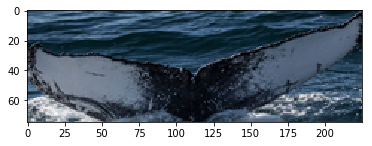

In [5]:
y_train, label_encoder = prepare_labels(data['Id'])

x_train = np.load('data/x_train_150x50_20190117.npy')
#x_train = prepareImages(data, len(data), 'train')
#np.save('data/x_train_225x75_20190117.npy', x_train)

print("Done")

plt.imshow(x_train[0])

In [6]:
#
direc1_interrupt = 'models/20190117_interrupt.h5'
direc1 = 'models/20190117_checkpoint.h5'
csv_logger = CSVLogger("models/20190117history.csv")

(x_train_mini, x_test_mini, y_train_mini, y_test_mini) = train_test_split(x_train, y_train, test_size=0.01, random_state=42)

#data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
#    samplewise_center=True,
#    samplewise_std_normalization=True,
#    zca_whitening=True,
    shear_range = 0.2,
    zoom_range = 0.2
)
datagen.fit(x_train_mini)

activation = 'relu'
cb_es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='auto')
check_point = ModelCheckpoint(direc1, monitor='val_loss', 
                              verbose=1, save_best_only=True, mode='auto', period=1)

#network (DenseNet + GAPNet)
dropRate = 0.3

xin = Input(shape=(75,225,3,))

blocks=[2,4,8,4]
n=16
k=32

x = Conv2D(n, (1,1), kernel_initializer='he_normal')(xin)
                                                                                                                                                                                                                                                                                                                                                                                                
x, n = dense_block(x, n, k, 2)
x, n = transition_layer(x, n)

x, n = dense_block(x, n, k, 4)
x, n = transition_layer(x, n)
                                                                                            
x, n = dense_block(x, n, k, 8)
x, n = transition_layer(x, n)

x, n = dense_block(x, n, k, 4)
x, n = transition_layer(x, n)

x, n = dense_block(x, n, k, 4)
x, n = transition_layer(x, n)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
x = GlobalAveragePooling2D()(x)

y = Dense(5005, activation = 'softmax')(x)

model = Model(xin, y)
                                                                                                                                                                                                                                                                                                                                                                                                                                    
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 225, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 75, 225, 16)  64          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 75, 225, 16)  64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 75, 225, 16)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
batch_size = 64

train_gen = datagen.flow(x_train_mini, y_train_mini, batch_size=batch_size)
stepsPepoch = math.ceil(len(x_train_mini) / batch_size)

adam = keras.optimizers.Adam(lr=0.001)
#weighted_categorical_crossentropy = weighted_categorical_crossentropy(weight)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

v_stepsPepoch = math.ceil(len(x_test_mini) / batch_size)

try:
    keras_history = model.fit_generator(train_gen,
                        steps_per_epoch=stepsPepoch, 
                        epochs=1000, 
                        validation_data= (x_test_mini, y_test_mini),
                        validation_steps = v_stepsPepoch,
                        callbacks=[cb_es, check_point, csv_logger], 
                        verbose=1)

except KeyboardInterrupt:
    print("keyboard interrupted")
    model.save(direc1_interrupt)

Epoch 1/1000
393/393 [==============================] - 246s 627ms/step - loss: 6.0642 - acc: 0.3793 - val_loss: 5.6499 - val_acc: 0.4094

Epoch 00001: val_loss improved from inf to 5.64985, saving model to models/20190117_checkpoint.h5
Epoch 2/1000
393/393 [==============================] - 238s 605ms/step - loss: 5.5435 - acc: 0.3801 - val_loss: 5.6083 - val_acc: 0.4094

Epoch 00002: val_loss improved from 5.64985 to 5.60827, saving model to models/20190117_checkpoint.h5
Epoch 3/1000
393/393 [==============================] - 238s 604ms/step - loss: 5.3312 - acc: 0.3792 - val_loss: 5.6277 - val_acc: 0.4055

Epoch 00003: val_loss did not improve from 5.60827
Epoch 4/1000
393/393 [==============================] - 238s 606ms/step - loss: 5.1208 - acc: 0.3785 - val_loss: 5.7511 - val_acc: 0.4094

Epoch 00004: val_loss did not improve from 5.60827
Epoch 5/1000
393/393 [==============================] - 238s 605ms/step - loss: 4.9253 - acc: 0.3772 - val_loss: 5.6441 - val_acc: 0.4055

Epo

393/393 [==============================] - 238s 604ms/step - loss: 0.9457 - acc: 0.7282 - val_loss: 4.8869 - val_acc: 0.4252

Epoch 00040: val_loss improved from 4.97293 to 4.88686, saving model to models/20190117_checkpoint.h5
Epoch 41/1000
393/393 [==============================] - 238s 605ms/step - loss: 0.9238 - acc: 0.7297 - val_loss: 5.3242 - val_acc: 0.4134

Epoch 00041: val_loss did not improve from 4.88686
Epoch 42/1000
393/393 [==============================] - 238s 605ms/step - loss: 0.9032 - acc: 0.7359 - val_loss: 5.3541 - val_acc: 0.3504

Epoch 00042: val_loss did not improve from 4.88686
Epoch 43/1000
393/393 [==============================] - 238s 605ms/step - loss: 0.8639 - acc: 0.7471 - val_loss: 5.2016 - val_acc: 0.3543

Epoch 00043: val_loss did not improve from 4.88686
Epoch 44/1000
393/393 [==============================] - 238s 606ms/step - loss: 0.8350 - acc: 0.7537 - val_loss: 4.9038 - val_acc: 0.3740

Epoch 00044: val_loss did not improve from 4.88686
Epoch 45


Epoch 00081: val_loss did not improve from 4.43276
Epoch 82/1000
393/393 [==============================] - 238s 605ms/step - loss: 0.3834 - acc: 0.8765 - val_loss: 5.1865 - val_acc: 0.4843

Epoch 00082: val_loss did not improve from 4.43276
Epoch 83/1000
393/393 [==============================] - 238s 606ms/step - loss: 0.3824 - acc: 0.8773 - val_loss: 4.9910 - val_acc: 0.4921

Epoch 00083: val_loss did not improve from 4.43276
Epoch 84/1000
393/393 [==============================] - 238s 605ms/step - loss: 0.3776 - acc: 0.8780 - val_loss: 5.0557 - val_acc: 0.5157

Epoch 00084: val_loss did not improve from 4.43276
Epoch 85/1000
393/393 [==============================] - 238s 605ms/step - loss: 0.3794 - acc: 0.8800 - val_loss: 5.0765 - val_acc: 0.4173

Epoch 00085: val_loss did not improve from 4.43276
Epoch 86/1000
393/393 [==============================] - 238s 605ms/step - loss: 0.3454 - acc: 0.8887 - val_loss: 4.7178 - val_acc: 0.5276

Epoch 00086: val_loss did not improve from 4

In [ ]:
#predict from submission.csv
batch_size = 128

direc_out = 'submissions/20190117_submission.csv'
#predict from submission.csv
batch_size = 64

model = keras.models.load_model(direc1)
#model = keras.models.load_model(direc1, custom_objects={'loss':weighted_categorical_crossentropy})
data_sub = pd.read_csv("data/sample_submission.csv", engine='python')
data_sub = pd.merge(data_sub, bounding_boxes, how="inner" ,on="Image")

data_sub['Id'] = ''
x_test = prepareImages(data_sub, len(data_sub), "test")
np.save('data/x_test_300x100_20190117.npy', x_test)
#x_test = np.load('data/x_test_300x100_20190117.npy')

predictions = model.predict(x_test, verbose=1)

for i, pred in tqdm(enumerate(predictions)):
    data_sub.loc[i, 'Id'] = ' '.join(label_encoder.inverse_transform(pred.argsort()[-5:][::-1]))

data_sub.to_csv(direc_out, index=False)